In [136]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from gaussian_system import System, time_matrix, estimate_log_marginal_at

In [138]:
path = Path.cwd().parent / "plots"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots')

In [139]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

In [5]:
t = time_matrix(100, 0.1)
marg_x = multivariate_normal(cov=system.corr_xx(t))
x = marg_x.rvs()
x

array([ -7.97215538,  -7.95283173,  -8.06308438,  -8.35064759,
        -8.29000611,  -8.06276633,  -8.14332644,  -8.24539438,
        -8.06975343,  -8.12586103,  -7.7211486 ,  -8.26536318,
        -8.0850265 ,  -7.55938679,  -7.70580599,  -7.30390853,
        -7.25064753,  -7.29531719,  -6.94692187,  -6.33778048,
        -6.13493711,  -5.8459766 ,  -6.0788529 ,  -5.54353432,
        -5.92909994,  -5.93980323,  -5.70713078,  -5.89309255,
        -5.44633906,  -5.81580834,  -5.76262089,  -5.92011518,
        -5.74946848,  -6.13063703,  -6.84945356,  -6.93778583,
        -6.74914072,  -6.31674336,  -6.08774021,  -6.43371847,
        -6.59320582,  -6.40768975,  -6.1938201 ,  -6.27802401,
        -6.15912405,  -6.25195931,  -6.5826186 ,  -7.14567561,
        -7.16827218,  -7.45536722,  -7.47452255,  -6.63254883,
        -6.81872603,  -7.57680182,  -7.4456393 ,  -7.38770325,
        -7.42101079,  -7.91981252,  -8.31055927,  -8.65394621,
        -9.01092605,  -8.60476726,  -8.40201497,  -8.59

In [14]:
data = pd.Series(estimate_log_marginal_at(x, 100000, system, t).squeeze())

(0.038394314735814644, -20.84728831392049, 0.022868615885189587)


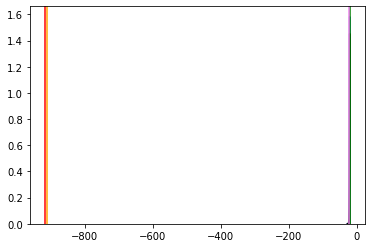

In [19]:
ax = sns.distplot(data)
fitparams = scipy.stats.loggamma.fit(data)
print(fitparams)
plot_range = numpy.linspace(data.min(), data.max(), 200)
plt.plot(plot_range, scipy.stats.loggamma.pdf(plot_range, *fitparams), "black")
(shape_param, offset, scale) = fitparams

plt.axvline(x=offset/scale + numpy.log(shape_param), color='red')
plt.axvline(x=offset/scale, color='orange')
plt.axvline(x=scipy.special.logsumexp(data, b=1/len(data)), color='green')
plt.axvline(x=data.mean(), color='violet')

In [124]:
data

NameError: name 'data' is not defined

In [75]:
marg_x.logpdf(x), logsumexp(data.log_likelihood, b=1/len(data.log_likelihood))

(-21.56338201036904, -21.537688162983294)

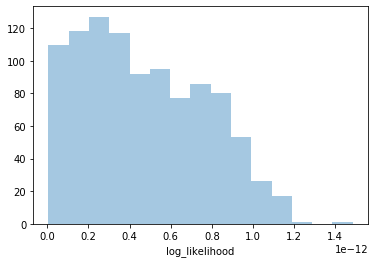

In [46]:
sns.distplot(numpy.exp(data['log_likelihood']), kde=False)

In [140]:
stochastic_data = pd.read_json(path / "log_likelihood" / "data2.json.zip")
stochastic_data

,duration,log_likelihood,sampled_from
0,0.057858,-3.840390,posterior
1,1.239993,-5.668387,posterior
2,1.330420,-6.511124,posterior
3,1.759608,-7.616291,posterior
4,3.180441,-9.687647,posterior
...,...,...,...
8540849,796.244495,-1385.125525,prior
8540850,797.282980,-1386.971693,prior
8540851,797.682494,-1388.163717,prior
8540852,797.985807,-1389.258724,prior


In [141]:
groups = stochastic_data.groupby('duration')
stochastic_data['ngroup'] = groups.ngroup() + 1
stochastic_data

,duration,log_likelihood,sampled_from,ngroup
0,0.057858,-3.840390,posterior,1
1,1.239993,-5.668387,posterior,2
2,1.330420,-6.511124,posterior,3
3,1.759608,-7.616291,posterior,4
4,3.180441,-9.687647,posterior,5
...,...,...,...,...
8540849,796.244495,-1385.125525,prior,850
8540850,797.282980,-1386.971693,prior,851
8540851,797.682494,-1388.163717,prior,852
8540852,797.985807,-1389.258724,prior,853


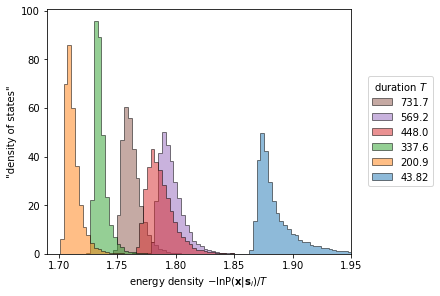

In [142]:
group_list = list(groups)[50::150]
histograms = [-group.log_likelihood / duration for duration, group in group_list]
labels = [f"{duration:.4}" for duration, _ in group_list]

fig, ax = plt.subplots(constrained_layout=True)
ax.hist(histograms, label=labels, bins='auto', density=True, alpha=0.5, histtype='stepfilled', edgecolor='k');
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", title="duration $T$");
ax.set(xlabel=r"energy density $-\ln\mathrm{P}(\mathbf{x}|\mathbf{s}_i) / T$", ylabel="\"density of states\"", xlim=(1.69, 1.95))
fig.savefig(path / "log_likelihood" / "histogram.pdf")

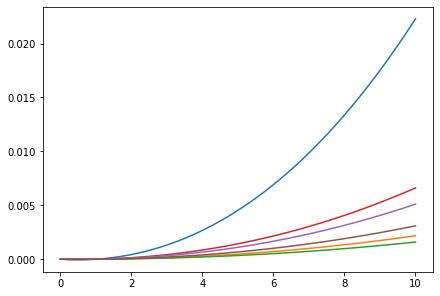

In [189]:
def moment_generating_function(data, t_vals):
    with np.nditer([t_vals, None]) as it:
        for t, r in it:
            r[...] = logsumexp(t * data, b=1/len(data)) - logsumexp(data, b=1/len(data)) * t
            # r[...] = 1/len(data) * np.sum(np.exp(t * data))
        return it.operands[1]

t_vals = np.linspace(0, 10, 50)
fig, ax = plt.subplots(constrained_layout=True)
for duration, group in group_list:
    ax.plot(t_vals, moment_generating_function(-group.log_likelihood / duration, t_vals))

(0.7032857414243779, -1388.6666056230397, 3.557206600454636)


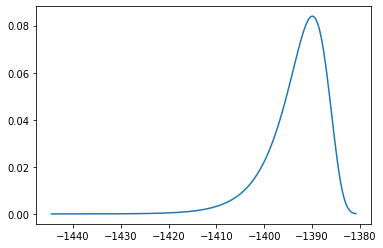

In [23]:
fitparams = scipy.stats.loggamma.fit(stochastic_hist.log_likelihood)
print(fitparams)
plot_range = numpy.linspace(stochastic_hist.log_likelihood.min(), stochastic_hist.log_likelihood.max(), 200)
plt.plot(plot_range, scipy.stats.loggamma.pdf(plot_range, *fitparams))

(0.7032857414243779, -1388.6666056230397, 3.557206600454636)


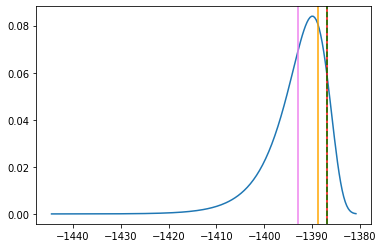

In [36]:
(shape_param, offset, scale) = fitparams
print(fitparams)
plt.plot(plot_range, scipy.stats.loggamma.pdf(plot_range, *fitparams))
plt.axvline(x=offset + numpy.log(scipy.special.gamma(shape_param + scale)/scipy.special.gamma(shape_param)), color='red')
plt.axvline(x=offset, color='orange')
plt.axvline(x=scipy.special.logsumexp(stochastic_hist.log_likelihood, b=1/len(stochastic_hist)), linestyle='--', color='green')
plt.axvline(x=stochastic_hist.log_likelihood.mean(), color='violet')

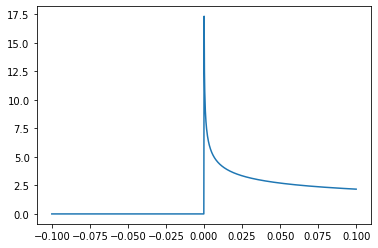

In [63]:
plt.plot(numpy.linspace(-0.1, 0.1, 1000), scipy.stats.gengamma.pdf(numpy.linspace(-0.1, 0.1, 1000)/scale, shape_param, 1))

In [60]:
(offset + numpy.log(scipy.special.gamma(shape_param + scale)/scipy.special.gamma(shape_param))) / scipy.special.logsumexp(stochastic_hist.log_likelihood, b=1/len(stochastic_hist))

0.9999792687123988